# **Receptive Fields:** Data Processing

**Note:** The different parts of this notebook are used as modules to run different parts of the data processing independently.

In [3]:
import sys
import time
import pickle
import hashlib
import numpy as np
import matplotlib.pyplot as plt

## Notebook Functions

### Data Handling Functions

In [4]:
_HASHLEN = 20  # Hash length for SHA-1

def progress_bar(i,N):
    """Print/update progress bar for i/N iterations.
    """
    a = i
    b = N - i
    
    print('\r' + u"\u2588" * a + '.' * b + ' (' + str(i) + '/' + str(N) + ')')

def safe_pickle(obj, filename):
    """Pickle a data object, append a checksum, and write to file.
    """
    # Pickle data
    pickled_data = pickle.dumps(obj)
    
    # Append with checksum
    pickled_data += hashlib.sha1(pickled_data).digest()
    
    # Write data to file
    with open(filename, 'wb') as outfile:
        outfile.write(pickled_data)

def safe_unpickle(filename):
    """Read pickled file, check hash, and return unpickled data.
    """
    
    print("Reading and unpickling data from \"" + filename + "\"...")
    
    # Read data from file
    with open(filename, 'rb') as infile:
        file_data = infile.read()
    
    # Retrieve pickled data and checksum
    pickled_data, checksum = file_data[:-_HASHLEN], file_data[-_HASHLEN:]
    
    # Check hash
    if hashlib.sha1(pickled_data).digest() != checksum:
        raise ValueError("Pickle hash does not match!")
    
    print("...done")
    
    # Return unpickled data
    return pickle.loads(pickled_data)

def gen_rand_stim(n):
    
    # ISI range
    a = 1e-3
    b = 50e-3
            
    # Spike times
    spk_times = np.array([])
    
    # Loop over receiving neurons
    for nrn in range(num_nrns):
            
        # Loop over lateral (delayed) input spikes
        for spike in range(num_lat):
            
            # Generate random interspike interval
            isi = random.uniform(a,b)
            spk_times = np.append(spk_times, -isi)
            
        # Direct excitation event - at "reference time"
        spk_times = np.append(spk_times, 0)
        
    # Spike source addresses
    spk_sources = np.arange(1, len(spk_times)+1)
    
    return spk_times, spk_sources

## SNN Setup

### Hyper-Parameters

In [12]:
# Neural-network parameters

num_columns = 5  # Number of network columns
num_lateral = 4  # Number of lateral inputs to B2 per side

chip_id = 0  # Hardware chip used for experiment

# Core IDs
core_dict = {
    'A': 0,   # Input neurons (virtual)
    'B1': 2,  # Secondary input neurons
    'B2': 1   # Coincidence detection neurons (read-out layer) | Core ID inherited from previous work
}

# Hardware neuron populations
populations = {
    'A': np.arange(
        256*core_dict['A'] + 1,
        256*core_dict['A'] + 256
    ),
    'B1': np.arange(
        256*core_dict['B1'],
        256*core_dict['B1'] + 256
    ),
    'B2': np.arange(
        256*core_dict['B2'],
        256*core_dict['B2'] + 256
    )
}

# Neuron IDs
neuron_dict = {
    'A': populations['A'],
    'B1': populations['B1'], #np.random.permutation(populations['B1']),
    'B2': populations['B2'] #np.random.permutation(populations['B2'])
}

# Number of parallel instances of network
#num_networks = int(len(population_A) / num_columns)
num_networks = 1

## Receptive Fields

### Setup

In [13]:
neurons_rf = np.array([
    10, 11, 14, 15, 19, 30, 34, 35, 45, 46, 47, 63, 65, 71, 74, 76, 79, 95,
    99, 107, 115, 129, 142, 160, 174, 188, 193, 205, 213, 217, 222, 230, 238,
    239, 248, 251
]) + 256*core_dict['B2']

print(neurons_rf)

[266 267 270 271 275 286 290 291 301 302 303 319 321 327 330 332 335 351
 355 363 371 385 398 416 430 444 449 461 469 473 478 486 494 495 504 507]


#### Random-Search Parameters

In [14]:
n_rand = int(10e3)  # Number of random-search iterations

stim_time = 100e-3  # Stimulation time

w_start = int(25e3)
w_stop = int(40e3 + 1)
w_step = int(5e3)

weights_de = range(w_start, w_stop, w_step)

n_weights = len(weights_de)

# Indices for neuron monitoring
mon_inds = range(0, 36, 8)
#mon_nrn_id = neurons_rf[mon_nrn_ind]

N = n_rand * len(weights_de)  # Total number of iterations

### Read Data from File

In [15]:
# Choose file, load, and unpickle the data
stimuli_rf = safe_unpickle(
    #"rf_data_oscilloscope_n5.pickle",
    #"rf_data_w10-50k_n1k.pickle",
    #"rf_data_w25-45k_n1k.pickle",
    "rf_data_w25-40k_n10k.pickle"
)

Reading and unpickling data from "rf_data_w25-40k_n10k.pickle"...
...done


In [16]:
print(len(stimuli_rf))

52256


### Data Processing

#### Multi-Neuron Plot

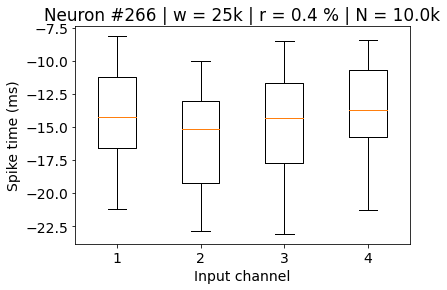

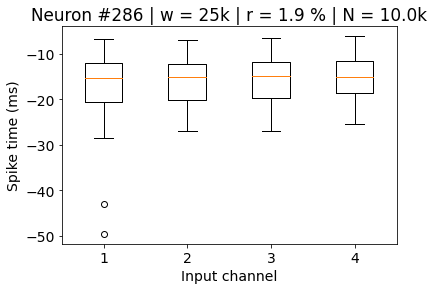

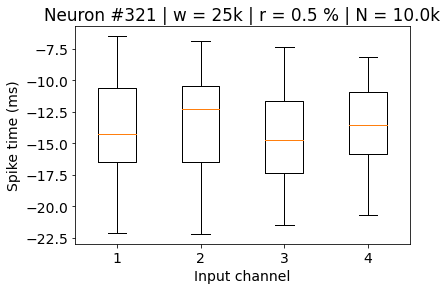

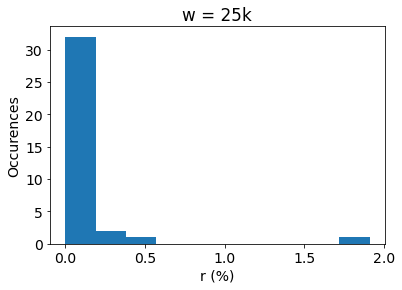

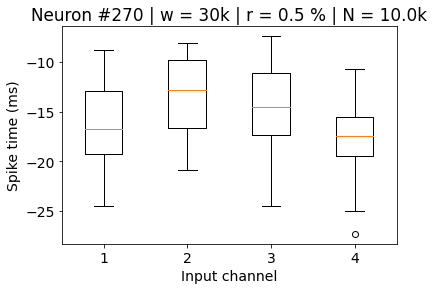

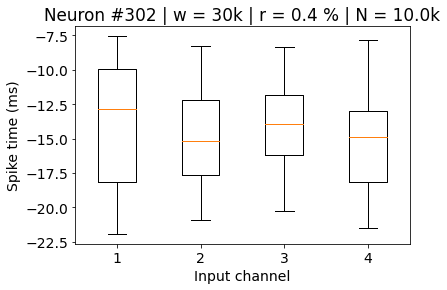

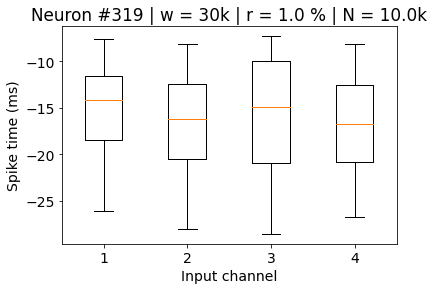

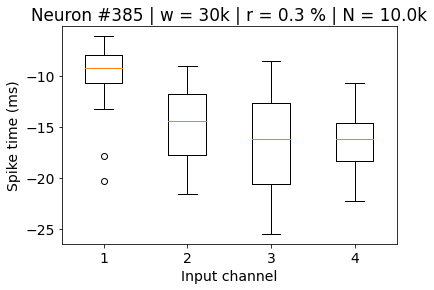

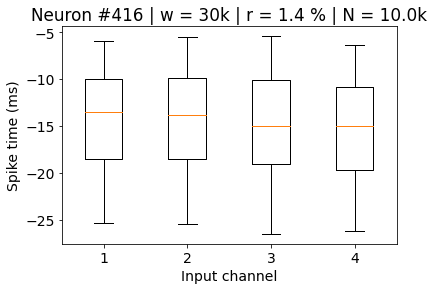

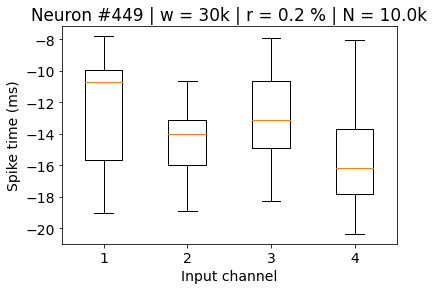

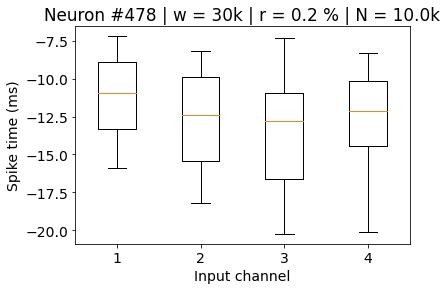

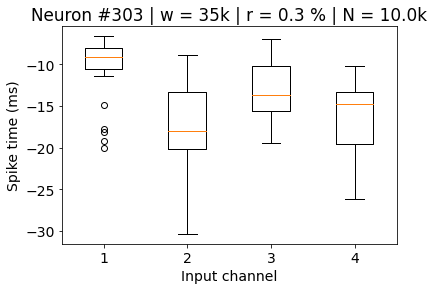

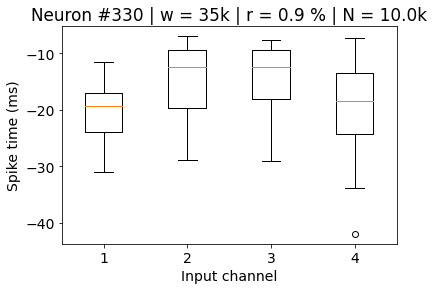

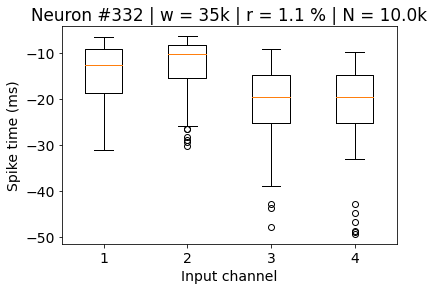

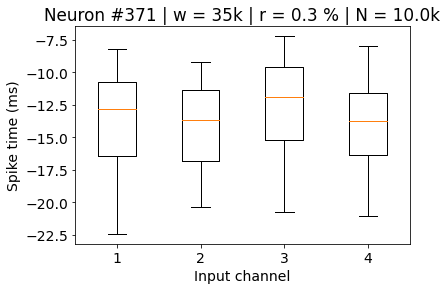

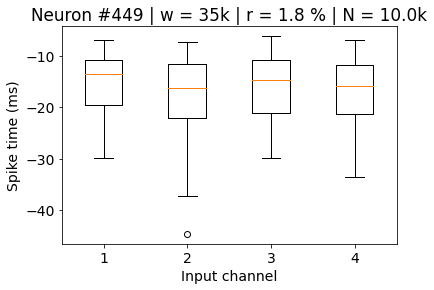

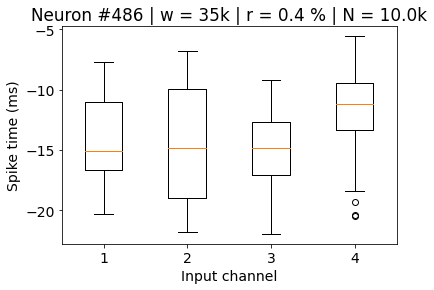

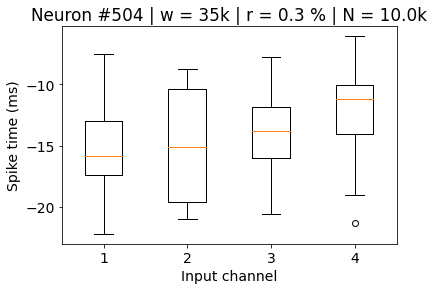

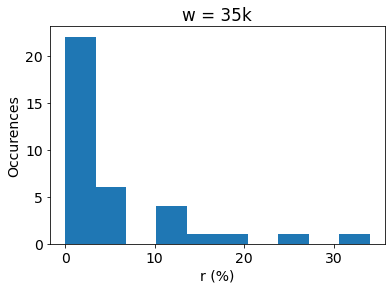

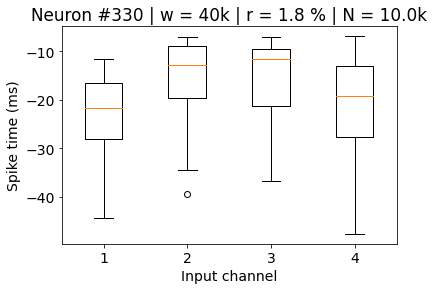

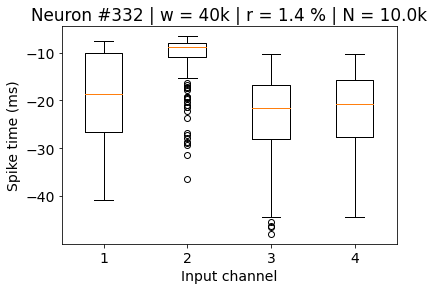

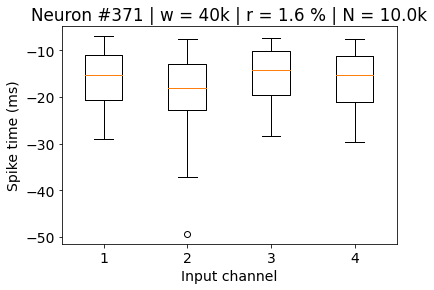

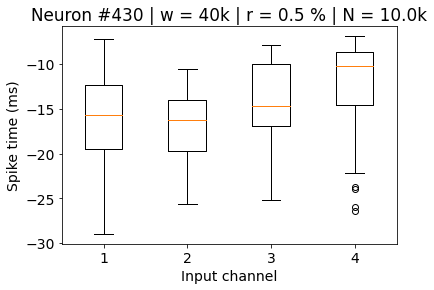

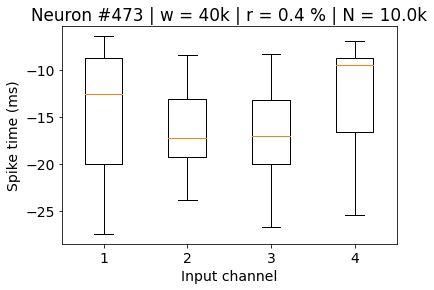

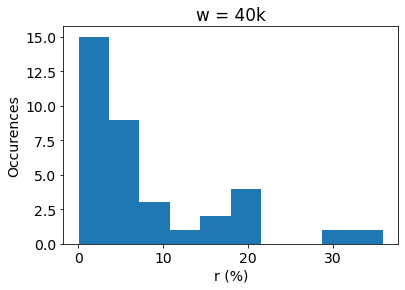

In [30]:
# Number of random iterations per weight-setting
#    Check this in data filename
N_plot = 10e3

r_min = 0.1e-2  # Min response ratio
r_max = 2e-2  # Max response ratio

channels = ['Ch 1', 'Ch 2', 'Ch 3', 'Ch 4']

# Loop over weights
for weight in weights_de:
    
    r_list = []
    
    # Loop over neurons
    for neuron in neurons_rf:
        
        # Neuron response counter
        resp_count = 0

        # Loop over stimuli
        for stimulus in stimuli_rf:
            
            # Check if stimulus belongs to current neuron/weight
            if(stimulus.neuron_id == neuron and stimulus.weight_de == weight):    
                
                # Add to response counter
                resp_count += 1
                
                # Check if first stimulus-data
                if resp_count == 1:
                    # Initialize histogram matrix
                    hist_mat = np.array([stimulus.pre_times[:-1]])
                else:
                    # Add stimulus data to histogram matrix
                    hist_mat = np.append(hist_mat,
                                         [stimulus.pre_times[:-1]],
                                         axis = 0)
    
        # Calculate response ratio for neuron/weight
        r = resp_count / N_plot
        r_list.append(r)
        
        # Check if within response-ratio bounds
        if (r_min <= r) and (r <= r_max):

            # Sort data by mean value
            mean = np.mean(hist_mat, axis = 0)
            order = np.argsort(mean)
            
            title_str = ("Neuron #" + str(neuron)
                         + " | w = "+ str(int(weight/1e3)) +'k'
                         + " | r = " + str(round(r*1e2, 1)) + ' %'
                         + " | N = " + str(N_plot/1e3) + 'k')
            
            # Box plot
            plt.figure()
            plt.title(title_str)
            plt.xlabel("Input channel")
            plt.ylabel("Spike time (ms)")
            #plt.boxplot(hist_mat[:,order] * 1e3)
            plt.boxplot(hist_mat * 1e3)
            #plt.ylim([-50, 0])
            plt.show()
    
    # r distribution
    plt.figure()
    plt.title("w = " + str(int(weight/1e3)) +'k')
    plt.xlabel("r (%)")
    plt.ylabel("Occurences")
    plt.hist(np.array(r_list) * 1e2)

In [17]:
# Choose file, load, and unpickle the data
stimuli_1 = safe_unpickle(filenames_in[0])

stimuli_2 = safe_unpickle(filenames_in[1])

stimuli_rf = stimuli_1 + stimuli_2

NameError: name 'filenames_in' is not defined

In [48]:
print(len(stimuli_1))
print(len(stimuli_2))
print(len(stimuli_rf))

12890
15175
28065


#### Manuscript Plots

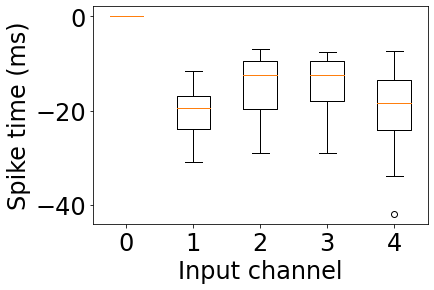

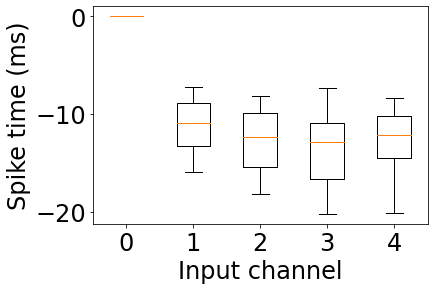

In [18]:
# Number of random iterations per weight-setting
#    Check this in data filename

neurons = [330, 385, 478, 504]
weights = [35e3, 30e3, 30e3, 40e3]

N_plot = 10e3

order = [4, 0, 1, 2, 3]

labels = range(5)

# Loop over neuron--weight--subplot combinations
for neuron, weight in zip(neurons, weights):

    # Plot-data matrix
    plot_data = []
    
    # Loop over stimuli
    for stimulus in stimuli_rf:

        # Check if stimulus belongs to current neuron/weight
        if(stimulus.neuron_id == neuron and stimulus.weight_de == weight):  

            # Add stimulus to plot data
            plot_data.append(stimulus.pre_times)

    plot_data_np = np.array(plot_data) * 1e3
    
    plt.figure()
    plt.rcParams['font.size'] = '24'
    plt.boxplot(plot_data_np[:,order], labels = labels)
    plt.xlabel("Input channel")
    plt.ylabel("Spike time (ms)")
    
    plt.savefig("Images/rf_nrn" + str(neuron) + ".eps",
                bbox_inches = 'tight')

#### Randomized Reference Stimuli

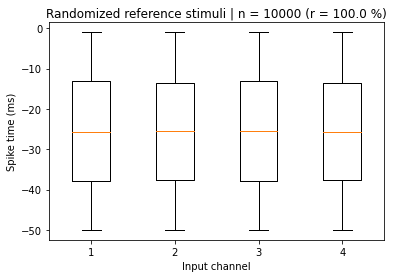

<AxesSubplot:>

In [84]:
from numpy.random import default_rng

# Instantiate random generator
rand_gen = default_rng()

# Number of random stimuli
n = int(10e3)
N = 10e3

# Random-distribution parameters
a = -50e-3
b = -1e-3

# Stimulus matrix size
size = [n, 4]

# Draw values from random distribution
rand_stim = rand_gen.uniform(a, b, size)

# Distance correlation matrix
dcor_mat = np.zeros((4,4))
for i in range(4):
    for j in range(4):
          dcor_mat[i,j] = dist_cor(rand_stim[:,i], rand_stim[:,j])

# Box plot
plt.figure()
plt.title("Randomized reference stimuli | n = " + str(n)
         +" (r = " + str(1e2*n/N) + ' %)')
plt.xlabel("Input channel")
plt.ylabel("Spike time (ms)")
plt.boxplot(rand_stim * 1e3)
plt.show()

# Distance-correlation heatmap
plt.figure()
sns.heatmap(
    dcor_mat,
    annot = True,
    vmin = 0,
    vmax = 1,
    #center = 0,
    mask = np.triu(dcor_mat),
    #cmap = 'coolwarm',
)

#### Oscilloscope Check

In [59]:
osc_nrns = neurons_rf[mon_inds]

stimuli_osc = safe_unpickle("rf_data_oscilloscope_n1.pickle")

weights_osc = np.array([25, 30, 35, 40, 45]) * 1e3

Reading and unpickling data from "rf_data_oscilloscope_n1.pickle"...
...done


In [58]:
print(osc_nrns)
print(osc_nrns - 256)

[266 301 335 430 494]
[ 10  45  79 174 238]
180


Neuron #266	1 spikes
Neuron #301	1 spikes
Neuron #335	1 spikes
Neuron #430	1 spikes
Neuron #494	1 spikes


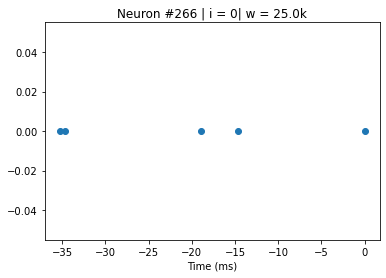

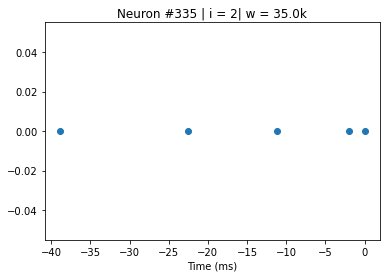

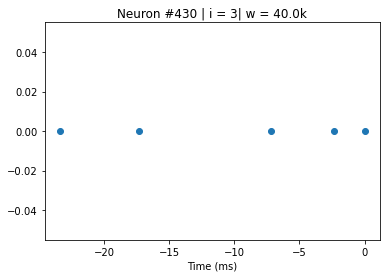

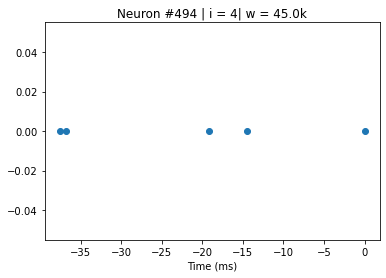

In [61]:
# Loop over monitored neurons
for i, neuron in enumerate(osc_nrns):
    
    # Reset counter
    counter = 0
    
    # Loop over stimulus data
    for stim in stimuli_osc:  
        
        # Check neuron ID
        if stim.neuron_id == neuron and stim.weight_de == weights_osc[i]:
            
            # Add to spike counter
            counter += 1
            
            # Plot stimulus
            plt.figure()
            plt.plot(
                stim.pre_times * 1e3,
                np.zeros_like(stim.pre_times),
                'o'
            )
            plt.title("Neuron #" + str(neuron)
                      + " | i = " + str(i)
                      #+ " | spike #" + str(counter)
                      + "| w = " + str(stim.weight_de/1e3) + 'k')
            plt.xlabel('Time (ms)')
    
    # Print amount of spikes
    print("Neuron #" + str(neuron) + '\t' + str(counter) + " spikes")
        

## Random CAM Search

### Load Data

In [6]:
n_spk_reg_list = safe_unpickle("n_spk_reg_1.pickle")
n_spk_inv_list = safe_unpickle("n_spk_inv_1.pickle")

Reading and unpickling data from "n_spk_reg_1.pickle"...
...done
Reading and unpickling data from "n_spk_inv_1.pickle"...
...done


In [8]:
print(len(n_spk_reg_list))
print()
print(len(n_spk_inv_list))

200

200


### Parameters

In [8]:
n_reg = np.array(n_spk_reg_list)
n_inv = np.array(n_spk_inv_list)

n_it = len(n_reg)  # Number of random search iterations
n_stim = 10         # Number of stimulus presentations per iteration

### Stimulus Plots

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


'\nplt.figure()\nplt.rcParams[\'font.size\'] = \'14\'\nplt.plot(stim_times_reg[order], \'o\')\nplt.xlabel("Input channel")\nplt.ylabel("Spike time (ms)")\nplt.xticks(range(5))\nplt.yticks([-20, -10, 0])\n\nplt.figure()\nplt.rcParams[\'font.size\'] = \'14\'\nplt.plot([1,2,3,4],\n         stim_times_inv[:-1],\n         \'o\')\nplt.xlabel("Input channel")\nplt.ylabel("Spike time (ms)")\nplt.xticks(range(5))\nplt.yticks([-20, -10, 0])\n'

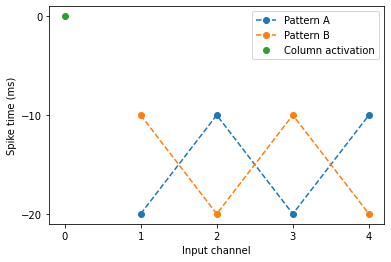

In [4]:
# "Sawtooth" stimulus
stim_times_reg = np.array([-20, -10, -20, -10, 0])

# Inverse "sawtooth" stimulus
stim_times_inv = np.array([-10, -20, -10, -20, 0])

labels = ["Pattern A",
          "Pattern B",
          "Column activation"]

plt.figure()
#plt.rcParams['font.size'] = '16'
plt.plot([1,2,3,4],
         stim_times_reg[:-1],
         '--o')
plt.plot([1,2,3,4],
         stim_times_inv[:-1],
         '--o')
plt.plot(0, 'o')
plt.legend(labels)
plt.xlabel("Input channel")
plt.ylabel("Spike time (ms)")
plt.xticks(range(5))
plt.yticks([-20, -10, 0])
plt.savefig("Images/saw_patterns.eps")
            #bbox_inches = 'tight')

"""
plt.figure()
plt.rcParams['font.size'] = '14'
plt.plot(stim_times_reg[order], 'o')
plt.xlabel("Input channel")
plt.ylabel("Spike time (ms)")
plt.xticks(range(5))
plt.yticks([-20, -10, 0])

plt.figure()
plt.rcParams['font.size'] = '14'
plt.plot([1,2,3,4],
         stim_times_inv[:-1],
         'o')
plt.xlabel("Input channel")
plt.ylabel("Spike time (ms)")
plt.xticks(range(5))
plt.yticks([-20, -10, 0])
"""

### Receptive Fields

In [6]:
stimuli_cam_rf = safe_unpickle(
    #"cam_rf_data_2021-05-12_18:08:38_n1000.pickle"
    #"cam_rf_data_2021-05-18_13:45:17_n10000.pickle"
    "cam_rf_data_2021-05-19_14:12:11_n10000.pickle"
)

Reading and unpickling data from "cam_rf_data_2021-05-19_14:12:11_n10000.pickle"...
...done


In [7]:
print(len(stimuli_cam_rf))

print()

716



response_counter = 121
response_counter = 307
response_counter = 163
response_counter = 125


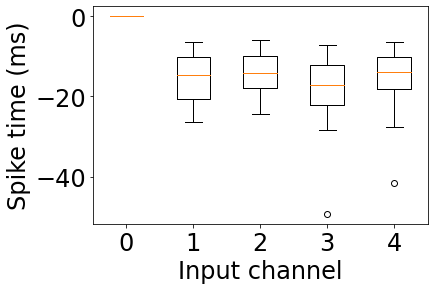

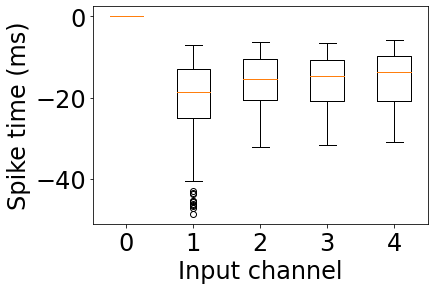

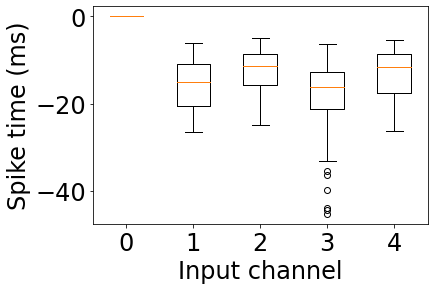

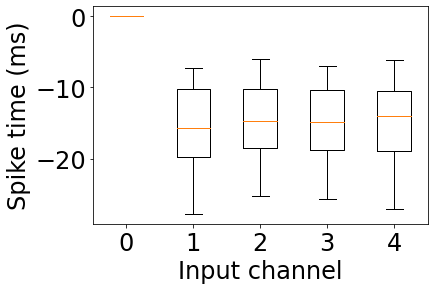

In [11]:
# Number of random iterations per weight-setting
#    Check this in data filename

inds = [0, 4, 58, 85]

order = [4, 0, 1, 2, 3]

labels = range(5)

# Loop over CAM combinations
for ind in inds:
    
    counter = 0
    
    # Plot-data matrix
    plot_data = []
    
    # Loop over stimuli
    for stimulus in stimuli_cam_rf:

        # Check if stimulus belongs to current neuron/weight
        if stimulus.index == ind:  

            # Add stimulus to plot data
            plot_data.append(stimulus.pre_times)
            
            counter += 1

    plot_data_np = np.array(plot_data) * 1e3
    
    if plot_data_np.size != 0:
        plt.figure()
        plt.rcParams['font.size'] = '24'
        plt.boxplot(plot_data_np[:,order], labels = labels)
        plt.xlabel("Input channel")
        plt.ylabel("Spike time (ms)")

        plt.savefig("Images/rf_cam_it" + str(ind) + ".eps",
                    bbox_inches = 'tight')
    
    print("response_counter = " + str(counter))